README:  
This solves the schrodinger equation for the hydrogen atom using the Verlet Algorithm

First define the ODE from Eq. 19.8 from Feynman's Lecture - The hydrogen atom

\begin{eqnarray}
\frac{1}{r}\frac{d^2}{dr^2}(r\psi) = -\frac{2m}{\hbar^2}(E + \frac{e^2}{r} - \frac{l(l+1)\hbar^2}{2mr^2})\psi \\
\psi(\infty) = 0
\end{eqnarray}

Eq. 19.13 changes the scale of the r and E such that 

\begin{equation}
\frac{d^2f}{d\rho^2} = - (\epsilon + \frac{2}{\rho} - \frac{l(l+1)}{\rho^2})f ~~,
\end{equation} 

where 
\begin{eqnarray}
\rho = \frac{r}{r_b} \\
\epsilon = \frac{E}{E_r} \\
f = \rho\psi \\
r_b ~~ \text{is the bohr radius} \\
E_r ~~ \text{is the Rydberg energy}
\end{eqnarray}

Boundary condition is $f(\infty) = 0$  
The last equality below is directly from rearranging the defined ODE

Clearly, we don't have the "velocity" (derivative of the psi)  
We therefore cannot use the ivp solver  
  
What we need is an ODE solver that doesn't need the velocity  
Solution: Verlet algorithm  
As per Matt Frick's summary, it solves ODEs using the taylor expansion  
It can solve an ODE by knowing any two points  
This is perfect for radial potentials because we know the points at far distances are zero  
We will then integrate backwards  

From Matt Frick's summary:  
"The Verlet algorithm is a means of calculating the next entry in a differential equation based on a third order Taylor expansion. Consider a differential equation of the form Ψ′′(x) = F[Ψ(x),x].   
By Taylor expanding about a point x, we can find an approximation for the value of Ψ at a distance δx away:  
Ψ(x + δx) = Ψ(x) + δxΨ′(x) + δx2F [Ψ(x), x] + δx3Ψ′′′(x) + O(δx4),   
Ψ(x − δx) = Ψ(x) − δxΨ′(x) + δx2F [Ψ(x), x] − δx3Ψ′′′(x) + O(δx4).  
Combining these equations to elimate the first and third derivatives, we find  
Ψ(x + δx) = 2Ψ(x) − Ψ(x − δx) + 2δx2F [Ψ(x), x], (30)  
which allows us to determine the next step in a series as long as we know the last two steps. Thus, if we know any two steps in a series we can find all the steps in that series by successive use of equation 30. This allows us to easily determine the radial wavefunction of a spherically symmetric system since we know that the radial wavefunction must tend to zero at infinite distances, or in the case of numerics, “large enough” distances." 

So instead of ivp solver, we formulate the verlet algorithm  
We take the system of taylor expansions:  
  
$f(\rho + d\rho) = f(\rho) + dxf'(\rho) + \frac{dx^2f''(\rho)}{2!} + \frac{dx^3f'''(\rho)}{3!} + ...$  
$f(\rho - d\rho) = f(\rho) - dxf'(\rho) + \frac{dx^2f''(\rho)}{2!} - \frac{dx^3f'''(\rho)}{3!} + ...$ 
  
Adding $f(\rho + d\rho)$ and $f(\rho - d\rho)$ together gives a RHS of:  

$f(\rho + d\rho)$ + $f(\rho - d\rho)$ = $2f(\rho) + 2*\frac{dx^2f''(\rho)}{2!}$
  
Rearranging gives the integration equation:  
  
$f(\rho - d\rho)$ = $2f(\rho) - f(\rho + d\rho) + 2\frac{dx^2f''(\rho)}{2!}$ 
  
Notice that in our second order ODE,  
  
$f''(\rho) = - (\epsilon + \frac{2}{\rho})f(\rho)$  
  
And so replacing the $f''(\rho)$ in the integration equation:  
  
$f(\rho - d\rho)$ = $2f(\rho) - f(\rho + d\rho) + 2\frac{dx^2(- (\epsilon + \frac{2}{\rho} - \frac{l(l+1)}{\rho^2})f(\rho) )}{2!}$  
  
Thus, if we know a value $f(\rho + d\rho)$ and the value before that, $f(\rho)$, we will know the value at an even earlier point, $f(\rho - d\rho)$.   
  
This allows us to integrate the wavefunction backwards since we know the end values (zero and close to zero)  

Flow chart for defining Verlet function:
1. Set the rho range (called rho) with an increment drho  
2. Initialize an zero list called f to hold the wavefunction - same length as rho  
3. Set the end values of f to be 0 and 10^-10  
4. Define the integration equation from above  
5. Loop over the integration equation, going backwards in index  
6. Normalize f  
7. Return f

For s orbitals previously: The analytical equation that we are using as comparison to our Verlet solver is from Feynman's Lectures - The hydrogen model:  
  
$\psi_n$ = $\frac{e^\frac{-\rho}{n}}{\rho}g_n(\rho)$  
where,  
  
$g_n(\rho) = \sum_{k=1}^{n} a_k\rho^k$  
  
$a_{k+1} = \frac{2(k/n -1)}{k(k+1)}a_k$  
  
For p orbitals, we turn to the book Molecular Symmetry by David Willock  
https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470747414.app9
page 360

********* n=2.00 **********


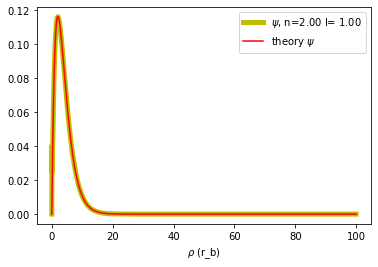

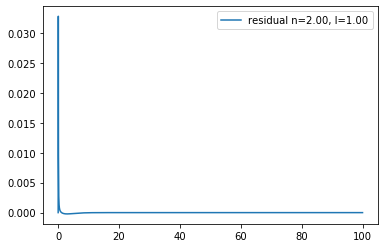

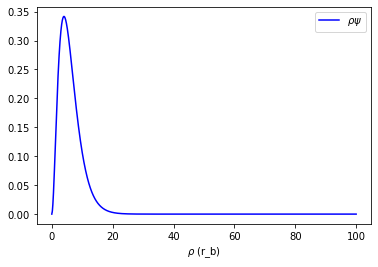

Value at r = 0   0.0
r_max = 100.00 * r_Bohr
********* n=3.00 **********


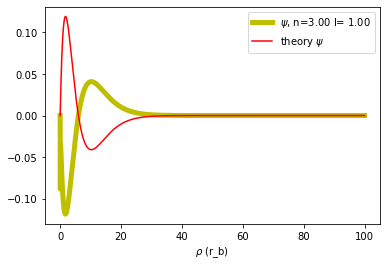

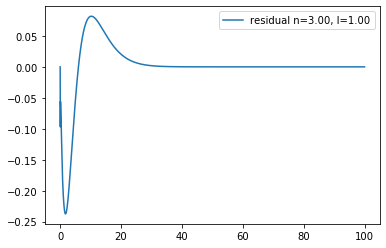

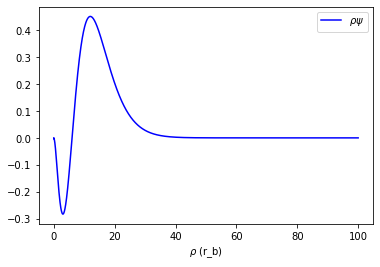

Value at r = 0   0.0
r_max = 100.00 * r_Bohr
********* n=3.00 **********


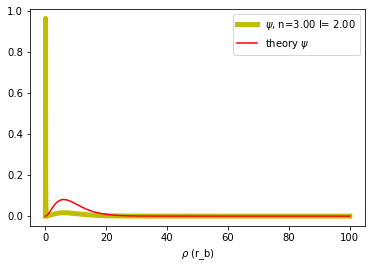

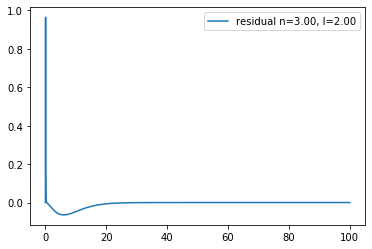

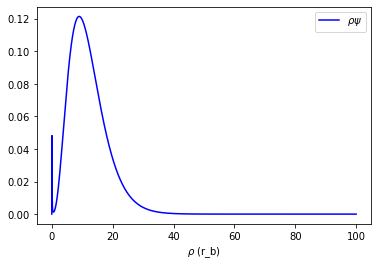

Value at r = 0   0.0
r_max = 100.00 * r_Bohr


In [16]:
# import packages
import numpy as np
import math
import matplotlib.pyplot as plt

# define rho
totrho = 2000
rho_min = 0
rho_max = 100
rho = np.linspace(rho_min, rho_max, totrho)

def Verlet(epsilon, l):
    # defining rho range
    totrho = 2000
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    drho = (rho_max)/(totrho)
    
    # initialize a zero list of the wavefunction of length rho
    length = totrho
    f = [0]*length
   
    # set the end values of f; mind the indexing 
    f[length - 1] = 0
    f[length - 2] = 10**-10
    
    for i in range(length-2, 1, -1):
        f[i-1] = 2*f[i] - f[i+1] + drho**2*(-epsilon - 2/rho[i] + l*(l+1)/(rho[i]**2))*f[i]
    
    #print('this is f', f)
    
    psi= [0]*length
    # solve for psi - wavefunction
    for i in range(1, length, 1):
        psi[i] = f[i]/rho[i]
    
    # normalize the wavefunction f
    # find the total sum (A) of all points of f
    A = 0 
    for i in range(length):
        A += psi[i]**2 # should be some factors of pi likely

    Norm = np.sqrt(A)
    psi = [x/Norm for x in psi]
    return psi # normalized wavefunction  

# Theory calc

# s-orbital
# From Feynman's hydrogen lecture
def theory_s_orbital(n):
    totrho = 2000
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    
    # coefficients in front of rho
    a = [0]*n
    a[0] = 1
    for i in range(1, n, 1):
        k = i
        a[i] = 2*(k/n -1)/(k*(k+1))*a[i-1]
    
    # multiply element-wise by rho^k
    g = [0]*totrho
    for i in range(totrho):
        for k in range(n):
            g[i] += a[k]*rho[i]**(k+1)
    
    # calculating psi
    psi = np.exp(-rho[1::]/n)/rho[1::]*g[1::]
    A = sum([x**2 for x in psi])
    psi_n = [x/np.sqrt(A) for x in psi]
    return psi_n

# p-orbital
def theory(n, l):
    totrho = 2000
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    psi = [0]*totrho
    
    if l == 1:
        if n == 2:
            psi = rho*np.exp(-rho/n)
        elif n == 3:
            psi = (4-2/n*rho)*(2/n)*rho*np.exp(-rho/n)
    elif l == 2:
        psi = 1/n**2*rho**2*np.exp(-rho/n)

    A = sum([x**2 for x in psi])
    psi_n = [x/np.sqrt(A) for x in psi]
    return psi_n


# plotting
n_max = 3
l_max = 2
for i in range(n_max):
    for j in range(l_max):
        n = i + 1
        l = j + 1
        if l >= n:
            continue 
        psi = Verlet(-1/n**2, l)
        theo = theory(n, l)
        print('********* n=%.2f **********'%(n))
        plt.plot(rho, psi, label = '$\psi$, n=%.2f l= %.2f' %(n, l), linewidth = 5, color = 'y')
        plt.plot(rho, theo, label = 'theory $\psi$', color = 'r')
        plt.xlabel("$\\rho$ (r_b)")
        plt.legend()
        plt.show()
    
    
        res1 = np.subtract(psi, theo)
        plt.plot(rho, res1, label = 'residual n=%.2f, l=%.2f' %(n, l))
        plt.legend()
        plt.show()    
    
        plt.plot(rho, rho*psi, label = '$\\rho\psi$', color = 'b')
        plt.xlabel("$\\rho$ (r_b)")
        plt.legend()
        plt.show()
    
        print('Value at r = 0  ', (rho*psi)[0])
        print('r_max = %.2f * r_Bohr' %(rho_max) )


Noticed that for n = 3, l = 2 the Verlet wavefunction and the analytical function are slightly off.  
Hence, here is what happens when we set the last points of the Verlet wavefunction as the same as the analytical function:

********* n=3.00 with analytical endpoints**********


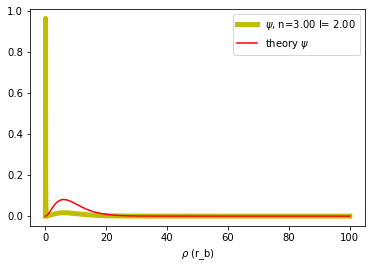

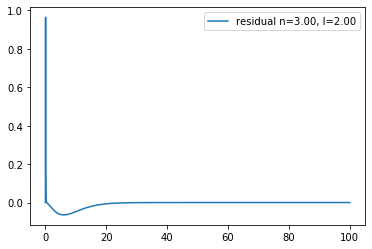

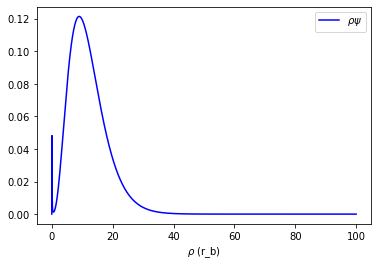

Value at r = 0   0.0
r_max = 100.00 * r_Bohr



In [18]:
def Verlet_modEndPoints(epsilon, l, M, N):
    # defining rho range
    totrho = 2000
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    drho = (rho_max)/(totrho)
    
    # initialize a zero list of the wavefunction of length rho
    length = totrho
    f = [0]*length
   
    # set the end values of f; mind the indexing 
    f[length - 1] = N
    f[length - 2] = M
    
    for i in range(length-2, 1, -1):
        f[i-1] = 2*f[i] - f[i+1] + drho**2*(-epsilon - 2/rho[i] + l*(l+1)/(rho[i]**2))*f[i]
    
    #print('this is f', f)
    
    psi= [0]*length
    # solve for psi - wavefunction
    for i in range(1, length, 1):
        psi[i] = f[i]/rho[i]
    
    # normalize the wavefunction f
    # find the total sum (A) of all points of f
    A = 0 
    for i in range(length):
        A += psi[i]**2 # should be some factors of pi likely

    Norm = np.sqrt(A)
    psi = [x/Norm for x in psi]
    return psi # normalized wavefunction  

# p-orbital
def theory(n, l):
    totrho = 2000
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    psi = [0]*totrho
    
    if l == 1:
        if n == 2:
            psi = rho*np.exp(-rho/n)
        elif n == 3:
            psi = (4-2/n*rho)*(2/n)*rho*np.exp(-rho/n)
    elif l == 2:
        psi = 1/n**2*rho**2*np.exp(-rho/n)

    A = sum([x**2 for x in psi])
    psi_n = [x/np.sqrt(A) for x in psi]
    return psi_n


for i in range(1):
    n = i + 3
    l = 2
    theo = theory(n, l)
    psi = Verlet_modEndPoints(-1/n**2, l, theo[-2], theo[-1])
    print('********* n=%.2f with analytical endpoints**********'%(n))
    plt.plot(rho, psi, label = '$\psi$, n=%.2f l= %.2f' %(n, l), linewidth = 5, color = 'y')
    plt.plot(rho, theo, label = 'theory $\psi$', color = 'r')
    plt.xlabel("$\\rho$ (r_b)")
    plt.legend()
    plt.show()
    

    res1 = np.subtract(psi, theo)
    plt.plot(rho, res1, label = 'residual n=%.2f, l=%.2f' %(n, l))
    plt.legend()
    plt.show()    
    
    plt.plot(rho, rho*psi, label = '$\\rho\psi$', color = 'b')
    plt.xlabel("$\\rho$ (r_b)")
    plt.legend()
    plt.show()
    
    print('Value at r = 0  ', (rho*psi)[0])
    print('r_max = %.2f * r_Bohr' %(rho_max) )
    print('')

    